In [1]:
import json
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import numpy as np
from datetime import datetime
import csv

In [149]:
## Read parameters

date_start = '2019-02-12 00:05:00'
date_end = '2019-02-13 10:00:00'
sensors = ['BS6', 'BS5', 'BS4', 'BS3', 'BS2', 'BS1']

root_path = '/Users/maggie/Desktop/test_folder'
#dates_folder = 'test_test'

date_rng = pd.date_range(start=date_start, end=date_end, freq='10s')

sensor = sensors[0]

In [166]:
## testing info - can delete
path1 = '/Users/maggie/Desktop/HPD_mobile/test_folder'
sensors = ['BS6', 'BS5', 'BS4', 'BS3', 'BS2', 'BS1']
name = sensor
root_directory = os.path.join(path1, name, 'env_params')
#print(root_directory)

day = datetime.now()
day = day.strftime("%Y-%m-%d")
print(day)



2019-02-20
/Users/maggie/Desktop/HPD_mobile/test_folder/Ground_truth


In [92]:
class ReadinData():
    def __init__(self, path1, name):
        self.root_directory = os.path.join(path1, name, 'env_params')
        self.root_dir = path1
        self.name = name
        self.data = {
            'time':[], 'tvoc_ppb':[], 'temp_c':[], 'rh_percent':[], 
            'light_lux':[],'co2eq_ppm':[], 'dist_mm':[], 'co2eq_base':[], 'tvoc_base':[]}
        
    def csv_name(self, sensor, day1, dayn):
        return str(sensor + '_' + day1 + '_to_' + dayn + '.csv')
        

    def make_storage_directory(self, root):
        target_dir = os.path.join(root, 'csv')
        if os.path.exists(target_dir):
            return target_dir
        else:
            os.mkdir(target_dir)
            return target_dir
        
    def mylistdir(self, directory):
        filelist = os.listdir(directory)
        return [x for x in filelist if not (x.startswith('.') or 'Icon' in x)]      

    def read_in_data(self, path):
        with open(path, 'r') as f:
            try:
                self.data_dicts = json.loads(f.read())
                for time_point in self.data_dicts:
                    for measure in time_point:
                        self.data[measure].append(time_point[measure])  
            except:
                pass

    def get_all_data(self, path):
        date_folders = self.mylistdir(path)
        day1, dayn = date_folders[-1], date_folders[0]
        for day in reversed(date_folders):
            file_path = os.path.join(path, day)
            minute_folders = self.mylistdir(file_path)
            for minute in minute_folders:
                sub_files_path = os.path.join(file_path, minute)
                sub_files = self.mylistdir(sub_files_path)
                for file in sub_files:
                    if file.endswith('.json') == True:
                        self.read_in_data(os.path.join(sub_files_path, file))
        self.d1, self.d2 = day1, dayn
        
    def clean_data(self, df):
        df['time'] = df['time'].str.strip('Z').str.replace('T',' ')
        df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
        df = df.sort_values(by = ['time'])
        return df   
    
    def write_data(self, df, day1 = None, dayn = None):
        storage_path = self.make_storage_directory(self.root_dir)
        target_fname = os.path.join(storage_path, self.csv_name(self.name, self.d1, self.d2))
        if os.path.isfile(target_fname) is False:
            df.to_csv(target_fname, index = False)
            print(target_fname + ' Write Sucessful!')
        else:
            print(target_fname + " File already exists")
            
    def get_ground_truth(self, full_df = None):
        ground_path = os.path.join(self.root_dir, 'GroundTruth')
        occupant_files = self.mylistdir(ground_path)
        occupants = {}
        for occ in occupant_files:            
            occupant_name = occ.split('-')[0]
            ishome = []
            with open(os.path.join(ground_path, occ)) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                for row in csv_reader:
                    status, when = row[1], row[2].split("at")
                    dt_day = datetime.strptime(str(when[0] + when[1]), '%B %d, %Y  %I:%M%p')
                    ishome.append((status, dt_day))
            occupants[occupant_name] = ishome
        return occupants
      
    def attach_ground_truth(self, df, occupants):
        for occ in occupants.keys():
            df[occ] = 99
            s1 = 'entered'
            for r in occupants[occ]:
                date = r[1]
                s2 = r[0]
                df.loc[(df['time'] < date) & (df[occ]==99) & (s1 == 'entered') & (s2 == 'exited'), occ] =  1
                df.loc[(df['time'] < date) & (df[occ]==99) & (s1 == 'exited') & (s2 == 'entered'), occ] =  0
                s1 = s2
        df['number'] = df[list(occupants.keys())].sum(axis = 1)
        df['occupied'] = 0
        df.loc[df['number'] > 0, 'occupied'] = 1
        
        return(df)
    
        
            
    def main(self):
        self.get_all_data(self.root_directory)
        self.new_df = pd.DataFrame.from_dict(self.data)
        self.gt = self.get_ground_truth()
        self.wTruth = self.attach_ground_truth(self.clean_data(self.new_df), self.get_ground_truth())
        self.write_data(self.wTruth)



In [93]:
root_path = '/Users/maggie/Desktop/HPD_mobile-H1'
sensors = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6']

for sensor in sensors:
    P = ReadinData(root_path, sensor)
    P.main()


/Users/maggie/Desktop/HPD_mobile-H1/csv/BS1_2019-02-17_to_2019-02-15.csv Write Sucessful!
/Users/maggie/Desktop/HPD_mobile-H1/csv/BS2_2019-02-13_to_2019-02-12.csv Write Sucessful!
/Users/maggie/Desktop/HPD_mobile-H1/csv/BS3_2019-02-13_to_2019-02-12.csv Write Sucessful!
/Users/maggie/Desktop/HPD_mobile-H1/csv/BS4_2019-02-13_to_2019-02-12.csv Write Sucessful!
/Users/maggie/Desktop/HPD_mobile-H1/csv/BS5_2019-02-13_to_2019-02-12.csv Write Sucessful!
/Users/maggie/Desktop/HPD_mobile-H1/csv/BS6_2019-02-10_to_2019-02-12.csv Write Sucessful!


In [ ]:
                
        """def clean_data(self, df):
        datetime_col = df['time'].str.split('T', n = 1, expand = True)
        df.insert(loc = 0, column = 'time_hour', value = datetime_col[1].str.replace('Z',''))
        df.insert(loc = 0, column = 'date', value = datetime_col[0])
        df = df.drop(columns = ['time'])
        df = df.sort_values(by = ['date', 'time_hour'])
        return df"""

In [668]:
dates = ['2019-02-12','2019-02-13']
#sensors = ['BS6', 'BS5', 'BS4', 'BS3', 'BS2', 'BS1']
sensors = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6']
start_path = '/Users/maggie/Desktop/HPD_mobile/HPD_csv/'

all_dfs = {}
num_nans = {}

#reading in csv files and writing as dataframes
for sensor in sensors:
    frames = []
    for date in dates:
        end_path = os.path.join(start_path, str(sensor + '-' + date + '.csv'))
        df = pd.read_csv(end_path)
        datetime_col = df['time'].str.split('T', n = 1, expand = True)
        df.insert(loc = 0, column = 'time_hour', value = datetime_col[1].str.replace('Z',''))
        df.insert(loc = 0, column = 'date', value = datetime_col[0])
        df = df.drop(columns = ['time', 'Unnamed: 0'])
        df = df.sort_values(by = ['date', 'time_hour'])
        frames.append(df)
                
    name = str(sensor)
    sensor_df = pd.concat(frames, ignore_index = True)
    na_counts = sensor_df.isnull().sum()
    num_nans[sensor] = na_counts
        
    all_dfs[name] = sensor_df 
    test_df = sensor_df

FileNotFoundError: File b'/Users/maggie/Desktop/HPD_mobile/HPD_csv/BS1-2019-02-12.csv' does not exist

# dataset analytics
number and percent of missing data values (nans)
percent of captured data points


In [92]:
percent_nans = {}

for df in all_dfs: 
    frame = all_dfs[df]
    end = frame['time_hour'].tail(1)
    perc = num_nans[df]/len(frame)
    high = 100 * perc.max()
    percent_nans[df] = high
print(percent_nans)

{'BS6': 4.722651554181693, 'BS5': 4.993673555461831, 'BS4': 5.2768021408262245, 'BS3': 5.055476766497039, 'BS2': 4.773703336636935, 'BS1': 30.87160108436704}


In [85]:
print(num_nans)    


{'BS6': date            0
time_hour       0
tvoc_ppb        0
temp_c        550
rh_percent    550
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS5': date            0
time_hour       0
tvoc_ppb        0
temp_c        592
rh_percent    592
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS4': date            0
time_hour       0
tvoc_ppb        0
temp_c        631
rh_percent    631
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS3': date            0
time_hour       0
tvoc_ppb        0
temp_c        606
rh_percent    606
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS2': date            0
time_hour       0
tvoc_ppb        0
temp_c        578
rh_percent    578
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: i

Sensor Hub BS6


AttributeError: Unknown property ylim

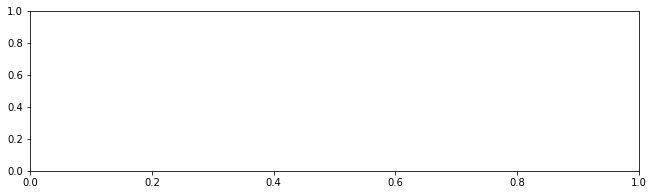

In [95]:
measures_to_plot = ['tvoc_ppb','temp_c','rh_percent','light_lux','co2eq_ppm','dist_mm']
colors = ['green', 'red', 'blue', 'orange', 'brown', 'grey']


for m, df in enumerate(all_dfs):
    print("Sensor Hub " + df)
    for n, measure in enumerate(measures_to_plot):
        plt.figure(figsize = (24,10))
        plt.subplot(3,2,n+1)

        plt.plot(all_dfs[df][measure], color = colors[m])
        if measure == 'rh_percent':
            plt.ylim = (0,100)
        plt.ylabel(measure)

        plt.savefig(df + ' - ' + measure)
    plt.show()  
